In [405]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
df = pd.read_csv(('../data/feature_engineered.csv'))
df.set_index('Timestamp', inplace=True)

In [406]:
train_test_split = 0.2
train_size = int((1 - train_test_split) * len(df))
df_train = df.iloc[:train_size]
df_test  = df.iloc[train_size:]

In [407]:
tune_split = int(0.8 * len(df_train))
train_tune = df_train.iloc[:tune_split]
val_tune   = df_train.iloc[tune_split:]


In [408]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

In [409]:
X_train_tune = train_tune.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_train_tune = train_tune['load_da']

X_val_tune = val_tune.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_val_tune = val_tune['load_da']

In [ ]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist',        # fast histogram algorithm
    eval_metric='rmse'
)

param_space = {
    'n_estimators': Integer(300, 700),          # more boosting rounds
    'max_depth': Integer(2, 8),                 # deeper trees
    'learning_rate': Real(0.001, 0.01, prior='log-uniform'),  # bigger steps
    'subsample': Real(0.1, 0.7),                 # less stochasticity
    'colsample_bytree': Real(0.4, 1.0),          # use more features per tree
    'min_child_weight': Integer(3, 7),           # allow finer splits
    'gamma': Real(0.0, 1.0),                     # weaker split penalty
    'reg_lambda': Real(0.3, 2.0, prior='log-uniform'),  # reduce L2
    'reg_alpha': Real(0.3, 2.0, prior='log-uniform'),   # reduce L1
}


tscv = TimeSeriesSplit(n_splits=6)

opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    n_iter=30,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train_tune, y_train_tune)
print("Best Parameters:", opt.best_params_)
print("Best CV Score:", -opt.best_score_)  # convert negative RMSE to positive



Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

In [411]:
best_xgb = opt.best_estimator_
best_xgb.fit(X_train_tune, y_train_tune)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.973286791785957, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=0.700621444621366, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.007441353369156513,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=385, n_jobs=-1,
             num_parallel_tree=None, ...)

In [412]:
X_test_tune = df_test.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_test_tune = df_test['load_da']

test_pred = best_xgb.predict(X_test_tune)

test_rmse = mean_squared_error(y_test_tune, test_pred, squared=False)

/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [413]:
# --- Train ---
train_pred = best_xgb.predict(X_train_tune)
train_rmse = mean_squared_error(y_train_tune, train_pred, squared=False)

# --- Validation (if you kept X_val_tune separately) ---
val_pred = best_xgb.predict(X_val_tune)
val_rmse = mean_squared_error(y_val_tune, val_pred, squared=False)



print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Train RMSE: 0.2775
Validation RMSE: 0.3534
Test RMSE: 0.3040


/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


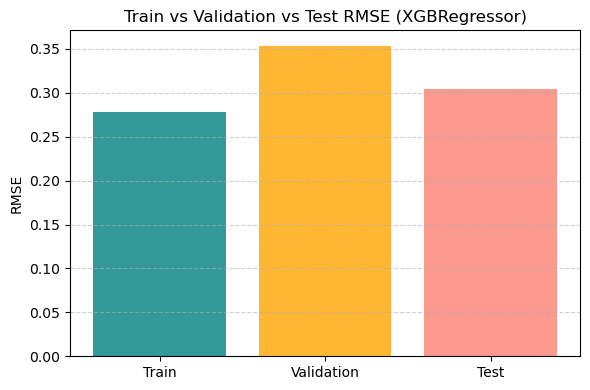

In [414]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Validation', 'Test'],
        [train_rmse, val_rmse, test_rmse],
        color=['teal', 'orange', 'salmon'], alpha=0.8)
plt.title('Train vs Validation vs Test RMSE (XGBRegressor)')
plt.ylabel('RMSE')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [415]:
X_train_tune = train_tune.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_train_tune = train_tune['load_d2']

X_val_tune = val_tune.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_val_tune = val_tune['load_d2']

In [416]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist',        # fast histogram algorithm
    eval_metric='rmse'
)

param_space = {
    'n_estimators': Integer(300, 700),          # more boosting rounds
    'max_depth': Integer(2, 8),                 # deeper trees
    'learning_rate': Real(0.001, 0.01, prior='log-uniform'),  # bigger steps
    'subsample': Real(0.1, 0.7),                 # less stochasticity
    'colsample_bytree': Real(0.4, 1.0),          # use more features per tree
    'min_child_weight': Integer(3, 7),           # allow finer splits
    'gamma': Real(0.0, 1.0),                     # weaker split penalty
    'reg_lambda': Real(0.3, 2.0, prior='log-uniform'),  # reduce L2
    'reg_alpha': Real(0.3, 2.0, prior='log-uniform'),   # reduce L1
}


tscv = TimeSeriesSplit(n_splits=6)

opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    n_iter=30,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train_tune, y_train_tune)
print("Best Parameters:", opt.best_params_)
print("Best CV Score:", -opt.best_score_)  # convert negative RMSE to positive

best_xgb = opt.best_estimator_
best_xgb.fit(X_train_tune, y_train_tune)

X_test_tune = df_test.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_test_tune = df_test['load_d2']

test_pred = best_xgb.predict(X_test_tune)

test_rmse = mean_squared_error(y_test_tune, test_pred, squared=False)

train_mae = mean_absolute_error(y_train_tune, train_pred)
test_mae = mean_absolute_error(y_test_tune, test_pred)
val_mae = mean_absolute_error(y_val_tune, val_pred)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

/Users/pranavsrinivasvenkatesh/anaconda3/envs/streamlitenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
